In [1]:
import abc
from collections import namedtuple
from skbio import TreeNode
import pandas as pd
import numpy as np
class ToyModel(TreeNode):
    """ 
    Parameters
    ----------
    use_lengths: bool
        Specifies if the branch lengths should be included in the
        resulting visualization (default True).
    Attributes
    ----------
    length
    leafcount
    height
    depth
    Notes
    -----
    `length` refers to the branch length of a node to its parent.
    `leafcount` is the number of tips within a subtree. `height` refers
    to the longest path from root to the deepst leaf in that subtree.
    `depth` is the number of nodes found in the longest path.
    """
    
    #Dont know if python has a built in stack.
    #I googled python stack and this was the first thing I saw
    class Stack:
        def __init__(self):
            self.items = []
            self.size = 0

        def isEmpty(self):
            return self.items == []

        def push(self, item):
            self.items.append(item)

        def pop(self):
            return self.items.pop()

        def peek(self):
            return self.items[len(self.items)-1]

        def size(self):
            return len(self.items)
    
    def __init__(self, use_lengths=True, **kwargs):
        """ Constructs a ToyModel object for visualization.
        """
        super().__init__(**kwargs)
        self.childRem = -1

    def _cache_ntips(self):
        """ Counts the number of leaves under each subtree."""
        for n in self.postorder():
            if n.is_tip():
                n.leafcount = 1
            else:
                n.leafcount = sum(c.leafcount for c in n.children)
                
    @classmethod
    def from_tree(cls, tree, use_lengths=True):
        """ Creates an UnrootedDendrogram object from a skbio tree.
        Parameters
        ----------
        tree : skbio.TreeNode
            Input skbio tree
        Returns
        -------
        UnrootedDendrogram
        """
        for n in tree.postorder():
            n.__class__ = ToyModel

        tree.update_geometry(use_lengths)
        return tree
    
    def update_geometry(self, use_lengths, depth=None):
        """Calculate tree node attributes such as height and depth.
        Parameters
        ----------
        use_lengths: bool
           Specify if the branch length should be incorporated into
           the geometry calculations for visualization.
        depth: int
           The number of nodes in the longest path from root to leaf.
        This is agnostic to scale and orientation.
        """
        if self.length is None or not use_lengths:
            if depth is None:
                self.length = 0
            else:
                self.length = 1

        self.depth = (depth or 0) + self.length

        children = self.children
        if children:
            for c in children:
                c.update_geometry(use_lengths, self.depth)
            self.height = max([c.height for c in children]) + self.length
            self.leafcount = sum([c.leafcount for c in children])

        else:
            self.height = self.length
            self.leafcount = self.edgecount = 1


    def coords(self, height, width):
        """ Returns coordinates of nodes to be rendered in plot.
        Parameters
        ----------
        height : int
            The height of the canvas.
        width : int
            The width of the canvas.
        Returns
        -------
        pd.DataFrame (Node metadata)
            index : str
                Name of node.
            Node id: str
                Name of node
            x : float
                x-coordinate of node.
            y : float
                y-coordinate of node.
        
        pd.DataFrame (Edge metadata)
            index : str
                Name of node.
            Node id: str
                Name of node
            x : float
                x-coordinate of node.
            y : float
                y-coordinate of node.
            Parent id:
                Name of parent
            px : float
                x-coorinate of parent
            py: float 
                y-coordinate of parent
        """
        
        #calculates coordinates of all nodes
        self.rescale(width, height)
        
        #Node metadata
        nodeData = {}
        for node in self.postorder():
            nId = {'Node id' : node.name}
            coords = {'x': node.x2, 'y': node.y2}
            nodeData[node.name] = {**nId,**coords}
            
        #edge metadata
        edgeData = {}
        for node in self.postorder():
            pId = {'Parent id' : node.name}
            pCoords = {'px': node.x2, 'py': node.y2}
            for child in node.children:
                nID = {'Node id' : child.name}
                coords = {'x': child.x2, 'y': child.y2}
                edgeData[child.name] = {**nId, **coords, **pId, **pCoords}

        #convert to pd.DataFrame
        nodeMeta = pd.DataFrame(nodeData).T
        edgeMeta = pd.DataFrame(edgeData).T
      
        return (nodeMeta,edgeMeta)

    def rescale(self, width, height):
        """ Find best scaling factor for fitting the tree in the figure.
        This method will find the best orientation and scaling possible
        to fit the tree within the dimensions specified by width and height.
        Parameters
        ----------
        width : float
            width of the canvas
        height : float
            height of the canvas
        Returns
        -------
        best_scaling : float
            largest scaling factor in which the tree can fit in the canvas.
        Notes
        -----
        """
        angle = (2 * np.pi) / self.leafcount
        # this loop is a horrible brute force hack
        # there are better (but complex) ways to find
        # the best rotation of the tree to fit the display.
        best_scale = 0
        for i in range(60):
            direction = i / 60.0 * np.pi
            # TODO:
            # This function has a little bit of recursion.  This will
            # need to be refactored to remove the recursion.

            points = self.update_coordinates(1.0, 0, 0, direction, angle)
            
            xs, ys = zip(*points)
            # double check that the tree fits within the margins
            scale = min(float(width) / (max(xs) - min(xs)),
                        float(height) / (max(ys) - min(ys)))
            # TODO: This margin seems a bit arbituary.
            # will need to investigate.
            scale *= 0.95  # extra margin for labels
            if scale > best_scale:
                best_scale = scale
                mid_x = width / 2 - ((max(xs) + min(xs)) / 2) * scale
                mid_y = height / 2 - ((max(ys) + min(ys)) / 2) * scale
                best_args = (scale, mid_x, mid_y, direction, angle)

        self.update_coordinates(*best_args)
        return best_scale

    def update_coordinates(self, s, x1, y1, a, da):
        """ Update x, y coordinates of tree nodes in canvas.
        `update_coordinates` will recursively updating the
        plotting parameters for all of the nodes within the tree.
        This can be applied when the tree becomes modified (i.e. pruning
        or collapsing) and the resulting coordinates need to be modified
        to reflect the changes to the tree structure.
        Parameters
        ----------
        s : float
            scaling
        x1 : float
            x midpoint
        y1 : float
            y midpoint
        a : float
            angle (degrees)
        da : float
            angle resolution (degrees)
        Returns
        -------
        points : list of tuple
            2D coordinates of all of the nodes.
        Notes
        -----
        This function has a little bit of recursion.  This will
        need to be refactored to remove the recursion.
        """
         
        #pushes nodes in a dfs fashion
        nodeStack = ToyModel.Stack()
        #what I use to determine which child to visit next/calculate 'a'
        childLeftToExplore = ToyModel.Stack()
        #stackFrame = [(s,x1,y1,x2,y2,a,da)]
        stackFrame = []
        
        curNode = self
        nodeStack.push(curNode)
        childLeftToExplore.push(curNode)
        
        #stores (x,y) of all leaf nodes
        points = []
        
          
        #Dirty attempts to simulate the recurisive method found in Gniess
        #Needs to be cleaned up
        #Note: This function assumes a node can have n-children
        #      I believe we are only going to use bifurcating trees
        #      which means this code can be cleaned up quite a bit
        while True: 
            
            #checks to see if the nodes has been visited
            if not hasattr(curNode,'childRem') or curNode.childRem == -1:
                # Constant angle algorithm.  Should add maximum daylight step.
                x2 = x1 + curNode.length * s * np.sin(a)
                y2 = y1 + curNode.length * s * np.cos(a)
                (curNode.x1, curNode.y1, curNode.x2, curNode.y2, curNode.angle) = (x1, y1, x2, y2, a)
                # TODO: Add functionality that allows for collapsing of nodes
                a = a - curNode.leafcount * da / 2
                stackFrame += [(s,x1,y1,x2,y2,a,da)] 
                
                #if node is a tip, remove from stack/add cords to points
                if curNode.is_tip():
                    points += [(x2,y2)]
                    nodeStack.pop()
                    del stackFrame[-1]
                    if not nodeStack.isEmpty():
                        curNode = nodeStack.peek()
                #if node is not a leaf, push left child to stack and update (s, x1, y1, a, da)
                else:
                    curNode.childRem = len(curNode.children)
                    nodeStack.push(curNode.children[-1*curNode.childRem])
                    childLeftToExplore.push(curNode.children[-1*curNode.childRem])
                    curNode.childRem -= 1
                    ca = curNode.children[0].leafcount* da
                    x1 = x2
                    y1 = y2
                    a = a + ca/2
                    curNode = nodeStack.peek()
        
            #if node has already been visited and still has children left to explore, push next child to
            #stack and update (s, x1, y1, a, da)
            elif curNode.childRem != 0:
                (s,x1,y1,x2,y2,a,da) = (stackFrame[-1])
                x1 = x2
                y1 = y2
                nodeStack.push(curNode.children[-1*curNode.childRem])
                childLeftToExplore.push(curNode.children[-1*curNode.childRem])
                curNode.childRem -= 1
                ca = curNode.children[-1*curNode.childRem].leafcount* da
                for i in range(0,len(curNode.children)-curNode.childRem):
                    ca = curNode.children[i].leafcount* da
                    if i != len(curNode.children)-curNode.childRem -1:
                        a = a + ca
                a = a + ca/2
            #if node has already been visited and doesn't have children left to explore, remove it from
            #stack as well as its ancestors if all of their children have been explored 
            #update (s, x1, y1, a, da)
            elif curNode.childRem == 0:
                nodeStack.pop()
                if len(stackFrame) != 0:
                    del stackFrame[-1]
                while not nodeStack.isEmpty() and nodeStack.peek().childRem == 0:             
                    nodeStack.pop()
                    del stackFrame[-1]
                if nodeStack.isEmpty():
                    break
                else:
                    curNode = nodeStack.peek()
                nodeStack.push(curNode.children[-1*curNode.childRem])
                childLeftToExplore.push(curNode.children[-1*curNode.childRem])
                curNode.childRem -= 1
                (s,x1,y1,x2,y2,a,da) = (stackFrame[-1])
                for i in range(0,len(curNode.children)-curNode.childRem):
                    ca = curNode.children[i].leafcount* da
                    if i != len(curNode.children)-curNode.childRem -1:
                        a = a + ca
                a = a + ca/2
                x1 = x2
                y1 = y2
                
            #Either set curNode to the top of stack or break the while loop 
            if not nodeStack.isEmpty():
                curNode = nodeStack.peek()
            else:
                break
          
        #reset nodes 
        while not childLeftToExplore.isEmpty():
            curNode = childLeftToExplore.peek()
            curNode.childRem = -1
            childLeftToExplore.pop()
        return points


In [2]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def plot(node_metadata, edge_metadata):
    """ Plot the tree with the given dataframe of coordinates of points

    We are now plotting with matplotlib
    Parameters
    ----------
    node_metadata : pd.DataFrame
       Contains all of the species attributes.
       Every row corresponds to a unique species
       and every column corresponds to an attribute.
       Metadata may also contain ancestors.
    edge_metadata : pd.DataFrame
       Contains all of the edge attributes.
       Every row corresponds to a unique edge
       and every column corresponds to an attribute.

    """
    # Plot nodes
    col_node_x = node_metadata['x']
    col_node_y = node_metadata['y']
    # TODO: annotation on points
    plt.scatter(col_node_x,col_node_y)

    # Plot edges
    # Get the four columns of coordinates
    col_edge_x = edge_metadata['x']
    col_edge_y = edge_metadata['y']
    col_edge_px = edge_metadata['px']
    col_edge_py = edge_metadata['py']

    row_count = len(edge_metadata.index)

    # Loop through each row and plot the edge
    for index in range(row_count):
        plot_x=[col_edge_x[index],col_edge_px[index]]
        plot_y=[col_edge_y[index],col_edge_py[index]]
        plt.plot(plot_x, plot_y)


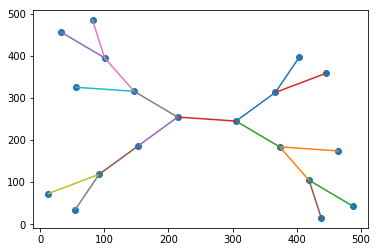

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from skbio import DistanceMatrix, TreeNode
from gneiss.plot._dendrogram import (Dendrogram, UnrootedDendrogram,
                                     SquareDendrogram)
from scipy.cluster.hierarchy import ward
import pandas.util.testing as pdt

np.random.seed(0)

# generate a random tree
x = np.random.rand(10)
dm = DistanceMatrix.from_iterable(x, lambda x, y: np.abs(x-y))
lm = ward(dm.condensed_form())  # hierarchical clustering
ids = np.arange(len(x)).astype(np.str)  # assign ids for each tip
tree = TreeNode.from_linkage_matrix(lm, ids) # create the tree
#print(tree.children[-1*len(tree.children)])
# initialize tree with branch length and named internal nodes
for i, n in enumerate(tree.postorder(include_self=True)):
    n.length = 1
    if not n.is_tip():
        n.name = "y%d" % i
t = ToyModel.from_tree(tree)
(nData, eData) = t.coords(500, 500)
plot(nData, eData)